In [313]:
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder,StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import graphviz 
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve,cross_val_score,ShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression,BayesianRidge
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import svm,metrics
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif,SelectFromModel


%matplotlib inline

with open('player_details.json') as json_data:
    d = json.load(json_data)
history = json_normalize(d, 'history', ['player_id'])
past = json_normalize(d, 'history_past', ['player_id'])
data = pd.read_json('players.json',orient='columns')
fixtures =  json_normalize(d, 'fixtures', ['player_id'])
teams = pd.read_json('teams.json',orient='columns')

player_type = pd.read_json('game-settings.json',orient='index')
player_type['element_type'] = player_type.index

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, X, y):
  #Make predictions on training set:
  predictions = []
  model.fit(X,y)
  predictions = model.predict(X)
  accuracy = metrics.accuracy_score(predictions,y)
  print ("Accuracy : %s" % "{0:.3%}".format(accuracy))
  
  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0],n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (X.iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = y.iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(X.iloc[test,:], y.iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(X,y) 

var_mod = ['photo','web_name','status','first_name','second_name','in_dreamteam','special','news']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

data['chance_of_playing_next_round'].fillna(100.0,inplace=True)
data['chance_of_playing_this_round'].fillna(100.0,inplace=True)
data.fillna(0.0,inplace=True)

team_avg = data.query('total_points>0')
team_avg = team_avg[['team','form']]
team_avg = team_avg.groupby(['team'],as_index=False).mean()
team_avg.columns = ['team','avg_team_form']
data = data.merge(team_avg,how='left',on='team')

#past.columns
past = past[['assists','bonus','bps','creativity','end_cost','goals_conceded','goals_scored','influence','minutes','own_goals',
           'penalties_missed','penalties_saved','red_cards','saves','season','start_cost','threat','total_points','yellow_cards',
           'player_id']]
past = past.query('season == 11')
past.columns = ['past_assists','past_bonus','past_bps','past_creativity','past_end_cost','past_goals_conceded','past_goals_scored',
                'past_influence','past_minutes','past_own_goals','past_penalties_missed','past_penalties_saved','past_red_cards',
                'past_saves','past_season','past_start_cost','past_threat','past_total_points','past_yellow_cards','id']
le = LabelEncoder()
past['id'] = le.fit_transform(past['id'])
past['past_creativity'] = le.fit_transform(past['past_creativity'])
past['past_influence'] = le.fit_transform(past['past_influence'])
past['past_threat'] = le.fit_transform(past['past_threat'])
data = data.merge(past,how='left',on='id')
#data.head()

player_type.columns = ['et_bps_clean_sheets','et_bps_goals_scored','et_scoring_clean_sheets','et_scoring_goals_conceded','et_scoring_goals_scored','et_squad_max_play',
             'et_squad_min_play','et_squad_select','et_sub_positions_locked','et_ui_shirt_specific','element_type']

player_t=player_type[['et_bps_clean_sheets','et_bps_goals_scored','et_scoring_clean_sheets','et_scoring_goals_conceded','et_scoring_goals_scored','et_squad_max_play',
             'et_squad_min_play','et_squad_select','element_type' ]]

data = data.merge(player_t,how='left',on='element_type')

teams.columns = ['team_code', 'current_event_fixture','draw','form','team'
                          ,'link_url','loss','team_name','next_event_fixture','played','points'
                          ,'position','short_team_name','strength','strength_attack_away',
                          'strength_attack_home','strength_defence_away','strength_defence_home','strength_overall_away',
                      'strength_overall_home','team_division','unavailable','win']

teams_n=teams[['team','strength','strength_attack_away','strength_defence_away','strength_overall_away',
               'strength_attack_home','strength_defence_home','strength_overall_home','short_team_name' ]]
le = LabelEncoder()
val_col = ['short_team_name']
for i in val_col:
    teams_n[i] = le.fit_transform(teams_n[i])
data = data.merge(teams_n,how='left',on='team')

C:\Users\ohass\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [314]:
#le = LabelEncoder()
history['player_id'] = history['player_id'].astype(str).astype(int)
#history =history[current_fix.id != 0]
history.drop('id', axis=1, inplace=True)
history = history.merge(data[['id','team']],how='left',left_on='player_id',right_on='id')
history.drop('id', axis=1, inplace=True)
team_diff = history.merge(teams_n,how='left',on=['team'])

In [315]:
team_diff = team_diff.merge(teams_n,how='left',left_on=['opponent_team'], right_on=['team'])
team_diff['strength_diff'] = team_diff['strength_x']-team_diff['strength_y']
team_diff['strength_attack_diff'] = np.where(team_diff['was_home']==True, team_diff['strength_attack_home_x']-team_diff['strength_defence_away_y'], team_diff['strength_attack_away_x']-team_diff['strength_defence_home_y'])
team_diff['strength_defence_diff'] = np.where(team_diff['was_home']==True, team_diff['strength_defence_home_x']-team_diff['strength_attack_away_y'], team_diff['strength_defence_away_x']-team_diff['strength_attack_home_y'])
team_diff['strength_overall_diff'] = np.where(team_diff['was_home']==True, team_diff['strength_overall_home_x']-team_diff['strength_overall_away_y'], team_diff['strength_overall_away_x']-team_diff['strength_overall_home_y'])
team_diff = team_diff[['opponent_team', 'was_home', 'player_id','round','minutes','total_points','value','transfers_balance','strength_diff','strength_attack_diff',
                       'strength_defence_diff','strength_overall_diff']]
data = team_diff.merge(data,how='left',left_on='player_id',right_on='id')

In [316]:
#data.query('total_points_y ==0')
#data.shape
data = data[data.total_points_y != 0]

In [320]:
outcome_var = 'total_points_x'
predictor_var_all = [
#'chance_of_playing_this_round', 'status',
'element_type','value_season',

'et_bps_clean_sheets','et_bps_goals_scored','et_scoring_clean_sheets',
'et_scoring_goals_conceded','et_scoring_goals_scored','et_squad_max_play','et_squad_min_play','et_squad_select',

'past_assists','past_bonus','past_bps','past_creativity','past_end_cost','past_goals_conceded','past_goals_scored',
'past_influence','past_minutes','past_own_goals','past_penalties_missed','past_penalties_saved','past_red_cards',
'past_saves','past_season','past_start_cost','past_threat','past_total_points','past_yellow_cards',

'team','strength','strength_attack_away',
'strength_attack_home','strength_defence_away','strength_defence_home','strength_overall_away',
'strength_overall_home','short_team_name','avg_team_form',

'value','transfers_balance','opponent_team', 'was_home','strength_diff','strength_attack_diff',
'strength_defence_diff','strength_overall_diff']

In [318]:
data.fillna(0.0,inplace=True)


In [321]:
X = data[predictor_var_all]
y = data[outcome_var]
n_sample = len(data)
X_train = X[:int(.7 * n_sample)]
y_train = y[:int(.7 * n_sample)]
X_test = X[int(.7 * n_sample):]
y_test = y[int(.7 * n_sample):]

Score:0.315546808229
Accuracy:0.315546808229


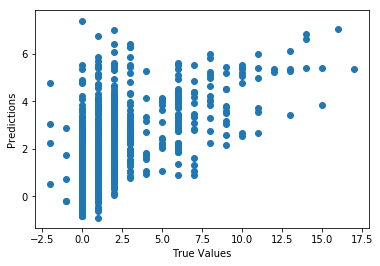

In [324]:
model = LinearRegression()
#classification_model(model, data,,data[outcome_var])
# Train the model using the training sets and check score
model.fit(X_train, y_train)
model.score(X_train, y_train)
#Equation coefficient and Intercept
#print('Coefficient: \n', model.coef_)
#print('Intercept: \n', model.intercept_)
#Predict Output
predicted= model.predict(X_test)

plt.scatter(y_test, predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print ('Score:'+str(model.score(X_test, y_test)))

accuracy = metrics.r2_score(y_test, predicted)
print('Accuracy:'+str(accuracy))

Score:-1.23707212531
Accuracy:-1.23707212531


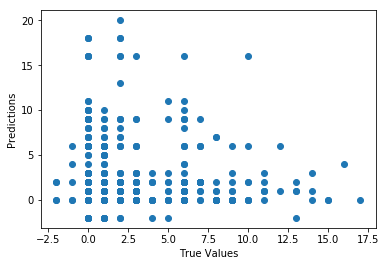

In [284]:
model2 = DecisionTreeRegressor()
# Train the model using the training sets and check score
model2.fit(X_train, y_train)
model2.score(X_train, y_train)
#Predict Output
predicted= model2.predict(X_test)
plt.scatter(y_test, predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print ('Score:'+str(model2.score(X_test, y_test)))

accuracy = metrics.r2_score(y_test, predicted)
print('Accuracy:'+str(accuracy))

Score:-0.0430054771945
Accuracy:-0.0430054771945


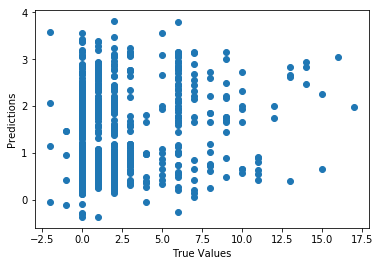

In [285]:
scaler = StandardScaler()
Xnew = scaler.fit_transform(X)
Xnew2 = pd.DataFrame(Xnew)
X_train2 = Xnew2[:int(.7 * n_sample)]
X_test2 = Xnew2[int(.7 * n_sample):]

model3 = svm.SVR()
# Train the model using the training sets and check score
model3.fit(X_train2, y_train)
model3.score(X_train2, y_train)
#Predict Output
predicted= model3.predict(X_test2)
plt.scatter(y_test, predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print ('Score:'+str(model3.score(X_test2, y_test)))

accuracy = metrics.r2_score(y_test, predicted)
print('Accuracy:'+str(accuracy))

In [41]:
params_grid = {'C': [0.001, 0.01, 0.1,0.8, 1,5, 10,50, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1,1],
          'kernel':['rbf'] }
#Create the GridSearchCV object
grid_clf = GridSearchCV(svm.SVC(class_weight='balanced'), params_grid)

#Fit the data with the best possible parameters
grid_clf = grid_clf.fit(Xnew, data[outcome_var])

#Print the best estimator with it's parameters
print (grid_clf.best_estimator_)

C:\Users\ohass\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


SVC(C=5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [292]:
scaler = StandardScaler()
X = scaler.fit_transform(data[predictor_var_all])
Xnew = pd.DataFrame(X)

model2 = svm.SVC(C=5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
classification_model(model2, data,Xnew,data[outcome_var])

Accuracy : 88.939%
Cross-Validation Score : 31.131%


In [290]:

model3 = DecisionTreeClassifier()
classification_model(model3, data,data[predictor_var_all],data[outcome_var])
#m = SelectFromModel(model3, prefit=True)
#X_new2 = m.transform(data[predictor_var_all])
#Xnew2 = pd.DataFrame(X_new2)
#classification_model(model3, data,Xnew2,data[outcome_var])

#cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
#plot_learning_curve(model3, 'Decision Tree 1', data[predictor_var_all], data[outcome_var], ylim=(0.3, 1.01), cv=cv, n_jobs=4)
#plot_learning_curve(model3, 'Decision Tree 2', Xnew2, data[outcome_var], ylim=(0.3, 1.01), cv=cv, n_jobs=4)
#plt.show()

Accuracy : 92.788%
Cross-Validation Score : 21.861%


In [286]:
model4 = RandomForestClassifier(n_estimators = 30,max_depth=7)#,max_features='log2')
classification_model(model4, data,data[predictor_var_all],data[outcome_var])
m = SelectFromModel(model4, prefit=True)
X_new2 = m.transform(data[predictor_var_all])
Xnew2 = pd.DataFrame(X_new2)
classification_model(model4, data,Xnew2,data[outcome_var])

Accuracy : 50.785%
Cross-Validation Score : 29.449%
Accuracy : 49.888%
Cross-Validation Score : 28.065%
